In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
from simplejson import JSONDecodeError
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import random
import time 


In [2]:
def parse_json(filepath):
    """
    function used to parse json of each commit json file

    Args:
        filepath_list - list of filepaths

    Returns:
        files_json - list object contains parsed information

    """

    files_json = []

    # each commits
    files = os.listdir(filepath)
    for path in files:
        if os.stat(filepath + path).st_size != 0 and path != 'desktop.ini':
            with open(filepath + path, encoding="utf8") as f:
                data = json.load(f)
                files_list = []
                # each file in commits
                for file in data['files']:
                    # parse only cluster file
                    for key in file.keys():
                        if re.match('^.*_cluster$', key):
                            actions_list = []
                            actions = file[key]['actions']
                            # each action in file
                            for action in actions:
                                actions_list.append(action['root'])
                            files_list.append(actions_list)
            if len(files_list) != 0:
                files_json.append(files_list)
    # return
    return files_json


folder_path = 'C:\\Users\\ichel\\Desktop\\shared_ReFiles\\AllFiles_Research\\'
all_files = parse_json(folder_path)

In [3]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0]
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split('to ')[0].strip()
                             ] + [temp.split('INS ')[1].split('to ')[-1].strip()]
                    for items in words:

                        items = items.split(': ')[0]
                        tempq.append(items)
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split(' from ')[1]
                    tempq.append('MOVE')
                    tempq.append(temp2.split(': ')[0])
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(': ')[0])
                    temp = '_'.join(tempq)
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i  
        i += 1
    return dic, files_data, counting 

In [4]:
dic, datas, freq_dict = preprocess_roots(all_files)
rev_dic = dict(zip(dic.values(), dic.keys()))

<sample training data>:  ['INS_ImportDeclaration_CompilationUnit INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_TagElement_Javadoc INS_TagElement_Javadoc', 'INS_SingleVariableDeclaration_MethodDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_VariableDeclarationStatement_Block INS_VariableDeclarationStatement_Block INS_ExpressionStatement_Block INS_ExpressionStatement_Block INS_SimpleName_ReturnStatement MOVE_VariableDeclarationFragment', 'INS_SimpleName_MethodInvocation INS_SimpleName_MethodInvocation INS_SimpleName_MethodInvocation']


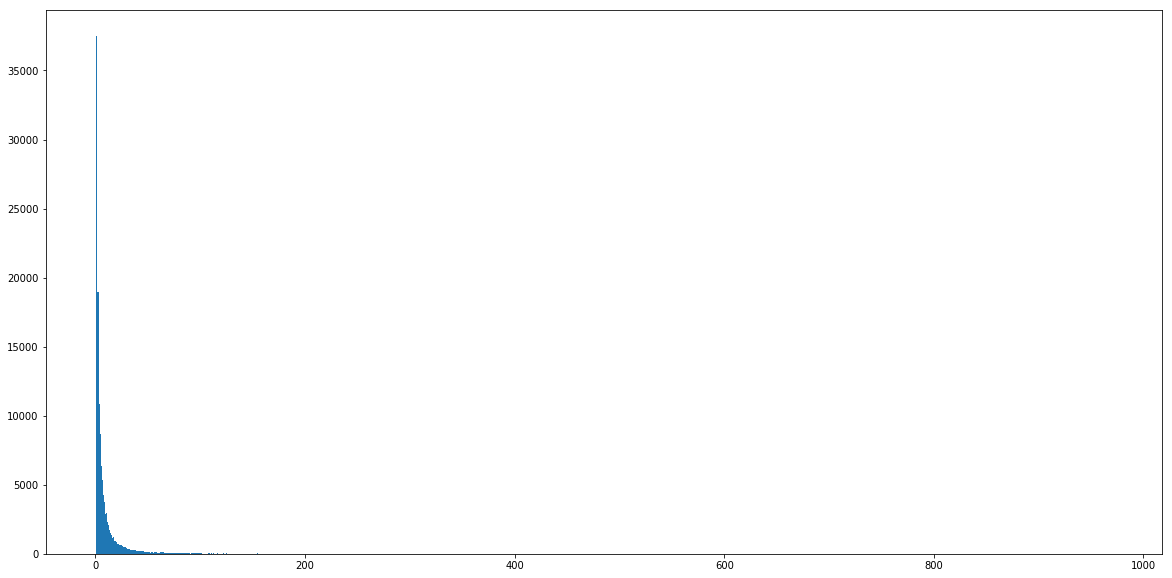

In [5]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)

def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for items in training_data:
        for item in items:
            seqlength_list.append(len(item.split(" ")))
            if len(item.split(" ")) >  max_root_len: 
                max_root_len = len(item.split(" "))
    return max_root_len, seqlength_list

def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)

max_seqlength, sequence_list = get_seqlength(training_data)
print("<sample training data>: ", training_data[0])
plot_hist(sequence_list)

In [43]:
def concat_train_data(training_data): 
    concat_data = ""
    tmp_list = []
    for items in training_data: 
        tmp_list += items
    concat_data = " ".join(tmp_list)
    return concat_data
    
def tokenize_train_data(concat_train_data): 
    data = []
    for word in concat_train_data.split():
        index = dic.get(word)
        if index is None: # for debug 
            print(word) # for debug 
        data.append(index)
    return data

tokenized_data = concat_train_data(training_data)
print(type(tokenized_data))
tokenized_data = tokenize_train_data(tokenized_data)

<class 'str'>
INS_TextElement_begin
validation
INS_TextElement:_do
so
INS_TextElement_begin
validation
INS_TextElement_use
this
implementation
by
simply
defining
this
file
INS_TextElement_be
successful
during
the
attempt,
or
perhaps
only
INS_TextElement_the
subject
INS_TextElement_be
dynamically
resolved
or
construtected
INS_TextElement_retrieve
a
script
INS_TextElement_run
the
compiler
in-process
in
Java,
you
should
look
INS_TextElement:_make
assertions
about
its
value
INS_TextElement_AST
Nodes
INS_TextElement_traverse
nodes
beginning
INS_TextElement:_make
assertions
about
its
value
INS_TextElement_avoid
invoking
the
soy
compiler
INS_TextElement_be
done
INS_TextElement_implement
both
interfaces
INS_TextElement_implement
both
interfaces
INS_TextElement_compute
this
list
INS_TextElement_have
weights
for
the
buckets
in
the
future,
take
a
look
INS_TextElement_have
weights
for
the
buckets
in
the
future,
take
a
look
INS_TextElement_garbage
collect
this
class
loader,
but
INS_TextElement_vali

## Subsampling 
Here we apply subsampling to get rid of roots such as "UPDATE", "INS_Method", which show up frequently in the dataset 
and could affect training speed and also the quality if the embeddings. The subsampling employed here is by Mikolov the creator of word2vec. For each root ri in the training set, we discard it with probability given by p(ri) = 1 - sqrt(1/(f(ri)).

In [40]:
def subsample(tokenized_data): 
    """
    Remove frequently occuring roots for faster training and better representation. 
    For the subsampling I am implementing Mikolov's negative.
    For each root ri it will discard it with the given probability p(ri) = 1 - sqrt(1/(f(ri)).
    :param tokenized_data: A list that contains the position in of each root in all commits into a single document 
    """
    threshold = 1e-5
    roots_count = Counter(tokenized_data)
    total_count = len(tokenized_data)
    freqs = {root: count/total_count for root, count in roots_count.items()}
    p_drop = {root: 1 - np.sqrt(threshold/freqs[root]) for root in roots_count}
    sampled_roots = [root for root in tokenized_data if random.random() < (1 - p_drop[root])]
    return sampled_roots 

sampled_roots = subsample(tokenized_data)
print(len(tokenized_data))
print(len(sampled_roots))

1296754
54028
138
39


## Make Batches 

In [8]:
def get_targets(roots, idx, window_size=8): 
    """
    Here we set window_size = 5 and select randomly a number N in the range (1:N)
    and then use N roots to current root and currnent + N roots in the future... reference roots as "words"
    :param roots: batch of sampled tokenized roots 
    :param idx: batch index 
    :param window_size: skip-gram window size -- HYPERPARAMETER 
    
    """
    N = np.random.randint(1, window_size + 1)
    start = idx - N if (idx - N) > 0 else 0 
    stop = idx + N
    targets = set(roots[start:idx] + roots[idx+1:stop+1])
    return list(targets)

In [9]:
def generate_batchs(roots, batch_size, window_size=8): 
    n_batches = len(roots)//batch_size 
    
    # make sure to select full batches 
    roots = roots[:n_batches * batch_size]
    
    for idx in range(0, len(roots), batch_size): 
        i, j = [], []
        batch = roots[idx:idx+batch_size]
        for ii in range(len(batch)): 
            batch_i = batch[ii]
            batch_j = get_targets(batch, ii, window_size)
            i.extend([batch_i] * len(batch_j))
            j.extend(batch_j)
        yield i, j

In [10]:
def print_sample_batch(tokenized_data=sampled_roots[:100]): 
    for ii in range(1): 
        batches = generate_batchs(tokenized_data, 10, 10)
        for i, j in batches: 
            print("epoch {}".format(ii))
            print("length of roots: {}".format(len(i)))
            print("roots: ")
            print(i)
            print("---------------")
            print("labels: ")
            print(np.array(j)[:, None])
            print(" ")
print_sample_batch()

epoch 0
length of roots: 54
roots: 
[467, 467, 467, 467, 467, 554, 554, 554, 554, 554, 554, 554, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 450, 450, 450, 450, 450, 450, 450, 450, 753, 450, 450, 450, 450, 450, 450, 450, 450, 730, 730, 730, 730, 730, 730, 59, 59, 59, 59, 59, 59, 229, 229, 229]
---------------
labels: 
[[450]
 [554]
 [753]
 [730]
 [327]
 [450]
 [229]
 [327]
 [753]
 [467]
 [730]
 [ 59]
 [450]
 [229]
 [327]
 [554]
 [753]
 [467]
 [730]
 [ 59]
 [450]
 [327]
 [450]
 [229]
 [327]
 [554]
 [753]
 [467]
 [730]
 [ 59]
 [450]
 [450]
 [229]
 [327]
 [554]
 [753]
 [467]
 [730]
 [ 59]
 [450]
 [229]
 [327]
 [554]
 [753]
 [ 59]
 [450]
 [229]
 [327]
 [554]
 [753]
 [730]
 [730]
 [450]
 [ 59]]
 
epoch 0
length of roots: 36
roots: 
[373, 373, 373, 373, 463, 463, 463, 574, 574, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 607]
---------------
labels: 
[[248]
 [161]
 [574]
 [463]
 [161]
 [373]
 [574]
 [

### Hyperparameters 

In [22]:
learning_rate = 0.001
vocab_size = len(dic)
rate = 0.4 # dropout_rate = 1 - rate 
embedding_size = 128  # number of embedding features 
num_sampled = 64 # number of negative examples to sample
epochs = 100000
batch_size = 128
window_size = 10

#Select random sample of most frequent words for model validation 
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.

## Build Network 
Input words are passed in as one-hot encoded vectors, which feed into a single hidden linear layer. 
The output of the embedding matrix of this network will then be fed into a CNN for prediction later on. 

### Initialize Graph
We have varying input sizes so we set the dimenision to **None** and the second dimension of the 
labels to **None** as well.

In [23]:
train_graph = tf.Graph()
with train_graph.as_default(): 
    inputs = tf.placeholder(tf.int32, [None], name="inputs")
    labels = tf.placeholder(tf.int32, [None, None], name="labels")

### Embedding 
Here the embedding matrix has the dimensions --> (tokenized_data X hidden_layers == embedding_size)

In [24]:
with train_graph.as_default(): 
    embedding = tf.Variable(tf.random_uniform((vocab_size, embedding_size), -1, 1))
    embedding = tf.nn.dropout(embedding, keep_prob=1 - rate, noise_shape=[vocab_size, 1])
    embed = tf.nn.embedding_lookup(embedding, inputs)

### Negative Sampling 

In [25]:
with train_graph.as_default(): 
    nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocab_size]))
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights, 
            biases=nce_biases, 
            labels=labels, 
            inputs=embed, 
            num_sampled=num_sampled, 
            num_classes=vocab_size
        )
    )
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) 

## Validation
pick most common and least common roots 

In [26]:
with train_graph.as_default(): 
    ## From Thusan Ganegedara's implementation 
    
    # pick top 8 samples from (0, 100) and (600, 700) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, random.sample(range(100, 600+valid_window), valid_size//2))
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # use cosine distance 
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding/norm 
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [27]:
# if the checkpoints directory does not exist then make it 
!mkdir checkpoints 

A subdirectory or file checkpoints already exists.


In [28]:
with train_graph.as_default(): 
    saver = tf.train.Saver()
with tf.Session(graph=train_graph) as sess:
    step = 1
    avg_loss = 0
    sess.run(tf.global_variables_initializer())
    for ii in range(1, epochs+1): 
        batches = generate_batchs(sampled_roots, batch_size, window_size)
        start = time.time()
        for i, j in batches: 
            feed = {inputs: i, labels: np.array(j)[:, None]}
            train_loss, _ = sess.run([loss, optimizer], feed_dict=feed)
            avg_loss += train_loss 
            if step % 100 == 0: 
                # Mat Leonard implementation 
                end = time.time()
                print("Epoch {}/{}".format(ii, epochs), 
                     "Iteration: {}".format(step), 
                     "Avg. Training loss: {:.4f}".format(avg_loss/100), 
                     "{:.4f} sec/batch".format((end - start)/100))
                avg_loss = 0
                start = time.time()
            if step % 10000 == 0: 
                sim = similarity.eval()
                for idx in range(valid_size): 
                    valid_word = rev_dic[valid_examples[idx]]
                    top_k = 8
                    nearest = (-sim[idx, :]).argsort()[1:top_k+1]
                    log = "Nearest to %s:" % valid_word 
                    for k in range(top_k):
                        close_word = rev_dic[nearest[k]]
                        log = "%s %s" % (log, close_word)
                    print(log)
            step += 1
    save_path = saver.save(sess, "checkpoints/word_embeddings.ckpt")
    embed_mat = sess.run(normalized_embedding)
                    
                
        

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'